## Le deuxième objectif du projet consiste à expliciter et à implémenter 2 approches de transfer learning : 
**A : l’utilisation des features d’un DL avant la couche dense comme représentation des images puis apprentissage d’un modèle de ML “classique”**
**B : fine-tuning d'un modèle existant à de nouvelles données**

# Transfer learning de type A 

In [1]:
#changement de répertoire
import os
os.chdir("C:/MLDL")

In [2]:
train_damage_dir = "C:/MLDL/train_another/damage"
validation_damage_dir = "C:/MLDL/validation_another/damage"
test_damage_dir = "C:/MLDL/test/damage"

train_nodamage_dir = "C:/MLDL/train_another/no_damage"
validation_nodamage_dir = "C:/MLDL/validation_another/no_damage"
test_nodamage_dir = "C:/MLDL/test/no_damage"

print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))
print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


## Avec VGG-16

In [3]:
#TRANSFER LEARNING
#The authors did : using feature extraction from ImageNet VGG16 - library : keras
#We do : using feature extraction from ImageNet VGG16 - library : pytorch
import torch
import torch.nn as nn
import torchvision.models as models

import torch.cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_base = models.vgg16(pretrained=True) # pre-trained model
conv_base = conv_base.to(device)
conv_base = torch.nn.Sequential(*list(conv_base.children())[:-2]) # remove the last layer

from torchsummary import summary
summary(conv_base, (3, 150, 150)) #same input shape #3 for RGB 150 x 150 pixels
#summary check : ok
#Total params: 14,714,688
#Trainable params: 14,714,688
#Non-trainable params: 0
#max Pool 2D : same layer, ok

C:\Users\chrys\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chrys\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [4]:
#Method 1: Fast feature extraction without data augmentation
#Run the conv_base on the dataset and save as Numpy array on disk
#Then build the dense layer on this
#This is faster to run, but we cannot augment the data

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

train_dir = "C:/MLDL/train_another"
validation_dir = "C:/MLDL/validation_another"
test_dir = "C:/MLDL/test"
#transform
data_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transform)
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

In [5]:
#define extract_features
#generators yield data indefinitely
#have to break after we have seen every image once
#try parallized (cuda)

import torch.cuda

def extract_features(dataloader, sample_count):
    batch_size = dataloader.batch_size
    features = torch.zeros(size=(sample_count, 4, 4, 512), dtype=torch.float32).to(device)
    labels = torch.zeros(size=(sample_count,1), dtype=torch.float32).to(device)
    
    with torch.no_grad():
        for i, (inputs_batch, labels_batch) in enumerate(dataloader):
            inputs_batch = inputs_batch.to(device)
            features_batch = conv_base(inputs_batch).view(inputs_batch.size(0), 4,4,512)
            features[i * len(inputs_batch): (i + 1) * len(inputs_batch)] = features_batch
            labels_batch = labels_batch.view(-1, 1)
            labels[i * len(inputs_batch): (i + 1) * len(inputs_batch)] = labels_batch.to(device)
            if i * batch_size >= sample_count:
                break
        return features, labels

In [7]:
# extraction
# Check if CUDA is available and move the features and labels to the GPU
train_features, train_labels = extract_features(train_loader, 10000)
if torch.cuda.is_available():
    train_features = train_features.cuda()
    train_labels = train_labels.cuda()

validation_features, validation_labels = extract_features(validation_loader, 2000)
if torch.cuda.is_available():
    val_features = validation_features.cuda()
    validation_labels = validation_labels.cuda()

test_features, test_labels = extract_features(test_loader, 2000)
if torch.cuda.is_available():
    test_features = test_features.cuda()
    test_labels = test_labels.cuda()

In [8]:
#flatten steps
train_features = train_features.reshape(10000, 512*4*4)
validation_features = validation_features.reshape(2000, 512*4*4)
test_features = test_features.reshape(2000, 512*4*4)

In [37]:
#define the densely connected layer
#import Optimizers
import torch.optim as optim

model = DenseNet()
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.conv_base = conv_base #to initialize the connection with the pre-trained model (whose dense layers were removed)
        self.fc1 = nn.Linear(512*4*4, 8192) #input_size (#256,1 defined per default as per see below)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(8192,20)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.shape[0], -1) # to reshape the inputs into 1 dimension
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [38]:
#Check whether customized dense layers are correctly connected to VGG16
from torchsummary import summary
print(model)

DenseNet(
  (conv_base): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# Define the loss function and the optimizer, with the same parameters as the scientists implemented

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss() #Binary cross-entrpoy
optimizer = optim.RMSprop(model.parameters(), lr=2e-5) 

for epoch in range(1):
    running_loss = 0.0
    accuracy = 0.0
    for i, data in enumerate(tqdm(train_loader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1,1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)

    with torch.no_grad():
        val_loss = 0.0
        accuracy_val = 0

        start = time.perf_counter()
        for val_data in validation_loader:
            val_inputs, val_labels = val_data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels.float().view(-1,1)).item()
            accuracy_val += (torch.round(val_outputs) == val_labels.float().view(-1,1)).sum().item() / len(val_labels)
        val_loss /= len(validation_loader)
        accuracy_val /= len(validation_loader)
        history['loss'].append(running_loss / 100)
        history['val_loss'].append(val_loss)
        history['acc'].append(accuracy / 100)
        history['val_acc'].append(accuracy_val)
        running_loss = 0.0
        accuracy = 0.0
        if i % 20 == 0: # Only print every 20 iterations
            print('Epoch {}/30, 500/500 [==============================] - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format(
                epoch + 1, history['loss'][-1], history['acc'][-1], history['val_loss'][-1], history['val_acc'][-1]))
end = time.perf_counter()

100%|██████████| 500/500 [1:13:36<00:00,  8.83s/it]


In [59]:
#save the model with pretrained features in Numpy array (no data augmentation)
torch.save(model.state_dict(), 'tomnod_transfer_VGG16.pt')

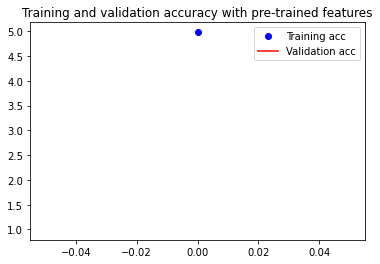

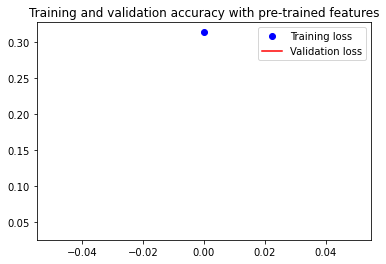

In [61]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy


plt.plot(epoch, history['acc'], 'bo', label='Training acc')
plt.plot(epoch, history['val_acc'], 'r', label='Validation acc')
plt.title('Training and validation accuracy with pre-trained features')
plt.legend()
plt.figure()
epochs = range(1, len(history['loss']) + 1)
plt.plot(epoch, history['loss'], 'bo', label='Training loss')
plt.plot(epoch, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation accuracy with pre-trained features')
plt.legend()


plt.show()

# Transfer learning de type B

In [ ]:
# The pre-trained convolutional base

In [72]:
import torch
import torch.nn as nn
import torchvision.models as models

import torch.cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_base = models.vgg16(pretrained=True) # pre-trained model
conv_base = conv_base.to(device)
conv_base = torch.nn.Sequential(*list(conv_base.children())[:-2]) # remove the last layer

from torchsummary import summary
summary(conv_base, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [73]:

#data augmentation with the same parameters used by the scientists
#freeze the paramters of the pre-trained network
for param in conv_base.parameters():
    param.requires_grad = False # les gradients ne seront pas calculés lors de la phse d'entaînement pour ces paramtères


# Add custom fully connected layers
class CustomClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_base = conv_base
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4*4*512, 256) #25088, poids de la dernière couche
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_base(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = CustomClassifier().to(device)

In [74]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns

#data augmentation   
train_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(1, 1), shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
])

train_dataset = datasets.ImageFolder(root='C:/MLDL/train_another', transform=train_datagen)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)

validation_dataset = datasets.ImageFolder(root='C:/MLDL/validation_another', transform=val_datagen)
validation_dataloader = DataLoader(validation_dataset, batch_size=20, shuffle=True)    

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# Define the loss function and the optimizer, with the same parameters as the scientists implemented

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss() #Binary cross-entrpoy
optimizer = optim.RMSprop(model.parameters(), lr=2e-5) 

for epoch in range(1):
    running_loss = 0.0
    accuracy = 0.0
    for i, data in enumerate(tqdm(train_loader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1,1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)

    with torch.no_grad():
        val_loss = 0.0
        accuracy_val = 0

        start = time.perf_counter()
        for val_data in validation_loader:
            val_inputs, val_labels = val_data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels.float().view(-1,1)).item()
            accuracy_val += (torch.round(val_outputs) == val_labels.float().view(-1,1)).sum().item() / len(val_labels)
        val_loss /= len(validation_loader)
        accuracy_val /= len(validation_loader)
        history['loss'].append(running_loss / 100)
        history['val_loss'].append(val_loss)
        history['acc'].append(accuracy / 100)
        history['val_acc'].append(accuracy_val)
        running_loss = 0.0
        accuracy = 0.0
        if i % 20 == 0: # Only print every 20 iterations
            print('Epoch {}/30, 500/500 [==============================] - loss: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_acc: {:.4f}'.format(
                epoch + 1, history['loss'][-1], history['acc'][-1], history['val_loss'][-1], history['val_acc'][-1]))
end = time.perf_counter()

100%|██████████| 500/500 [22:35<00:00,  2.71s/it]


In [76]:
#save the model with transfer learning and data augmentation
torch.save(model.state_dict(), 'tomnod_transfer_dataAugment.pt')

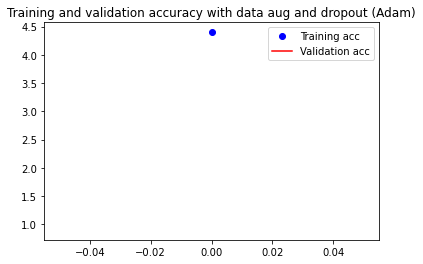

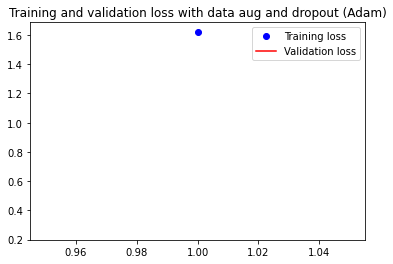

In [77]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy


plt.plot(epoch, history['acc'], 'bo', label='Training acc')
plt.plot(epoch, history['val_acc'], 'r', label='Validation acc')
plt.title('Training and validation accuracy with data aug and dropout (Adam)')
plt.legend()
plt.figure()
epoch = range(1, len(history['loss']) + 1)
plt.plot(epoch, history['loss'], 'bo', label='Training loss')
plt.plot(epoch, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss with data aug and dropout (Adam)')
plt.legend()


plt.show()